### Imports

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,\
    GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,\
    FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,\
    GradientBoostingClassifier, AdaBoostClassifier,\
    BaggingClassifier, ExtraTreesClassifier,\
    VotingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve

import xgboost

import pickle

from imblearn.pipeline import Pipeline as ImPipeline

#https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
from sklearn.metrics import roc_curve
from numpy import sqrt, argmax

import model

In [10]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

The 'import model' line is for a class ModelWithCV. 

In [45]:
# class ModelWithCV():
#     '''Structure to save the model and more easily see its crossvalidation'''
    
#     def __init__(self, model, model_name, X, y, cv_now=True):
#         self.model = model
#         self.name = model_name
#         self.X = X
#         self.y = y
#         # For CV results
#         self.cv_results = None
#         self.cv_mean = None
#         self.cv_median = None
#         self.cv_std = None
#         #
#         if cv_now:
#             self.cross_validate()
        
#     def cross_validate(self, X=None, y=None, kfolds=10):
#         '''
#         Perform cross-validation and return results.
        
#         Args: 
#           X:
#             Optional; Training data to perform CV on. Otherwise use X from object
#           y:
#             Optional; Training data to perform CV on. Otherwise use y from object
#           kfolds:
#             Optional; Number of folds for CV (default is 10)  
#         '''
        
#         cv_X = X if X else self.X
#         cv_y = y if y else self.y

#         self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
#         self.cv_mean = np.mean(self.cv_results)
#         self.cv_median = np.median(self.cv_results)
#         self.cv_std = np.std(self.cv_results)

        
# #     def print_cv_summary(self):
# #         cv_summary = (
# #         f'''CV Results for `{self.name}` model:
# #             {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
# #             recall_score: {recall_score(self.y, self.model.predict(self.X))}
# #             precision_score: {precision_score(self.y, self.model.predict(self.X))}
# #             f1_score: {f1_score(self.y, self.model.predict(self.X))}    
# #         ''')
# #         print(cv_summary)
#     def print_cv_summary(self):
#         cv_summary = (
#         f'''CV Results for `{self.name}` model:
#             {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
#             recall_score: {cross_val_score(self.model, self.X, self.y, cv=10, scoring='recall').mean()}
#             precision_score: {cross_val_score(self.model, self.X, self.y, cv=10, scoring='average_precision').mean()}
#             f1_score: {cross_val_score(self.model, self.X, self.y, cv=10, scoring='f1').mean()}    
#         ''')
#         print(cv_summary)
        
#     def plot_cv(self, ax):
#         '''
#         Plot the cross-validation values using the array of results and given 
#         Axis for plotting.
#         '''
#         ax.set_title(f'CV Results for `{self.name}` Model')
#         # Thinner violinplot with higher bw
#         sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
#         sns.swarmplot(
#                 y=self.cv_results,
#                 color='orange',
#                 size=10,
#                 alpha= 0.8,
#                 ax=ax
#         )

#         return ax

### Problem Description

The Mayo Clinic has tasked us with predicting how likely individuals are to receive the seasonal flu vaccine. 
We will concentrate on:
- Predicting who will get the seasonal vaccine?
- The most significant features in determining whether or not an individual will get vaccinated? 
- How can we get more people to get vaccinated?

### Data

The data was provided by DrivenData as a part of their competition. Details about the competition and getting the data can be found https://www.drivendata.org/competitions/66/flu-shot-learning/

The data was provided in two separate files, which were combined for cleaning splitting again later. 

In [16]:
training_set_features = pd.read_csv('../Data/training_set_features.csv')
training_set_labels = pd.read_csv('../Data/training_set_labels.csv')
complete_data = pd.merge(training_set_features, training_set_labels, on='respondent_id')

In [17]:
complete_data.isna().sum().sort_values(ascending=False).head(10)

employment_occupation    13470
employment_industry      13330
health_insurance         12274
income_poverty            4423
doctor_recc_h1n1          2160
doctor_recc_seasonal      2160
rent_or_own               2042
employment_status         1463
marital_status            1408
education                 1407
dtype: int64

There are a considerable number of NA values in the dataset.

If the employment_status column has a value of Not in Labor Force, then columns employment_industry and employment_occupation will have NA's. 

Values in columns employment_industry and employment_occupation are represented as short random character strings. 

We will be filling NA's in employment_occupation and employment_industry associated with "Not in Labor Force" with because they would otherwise be imputed as the most frequent occupation or industry.

Filling Unemployed with "Not in Labor Force".

In [18]:
complete_data['employment_status'].replace("Unemployed", "Not in Labor Force", inplace=True)
complete_data.loc[complete_data['employment_status'] == "Not in Labor Force", 'employment_industry'] = "Not in Labor Force"
complete_data.loc[complete_data['employment_status'] == "Not in Labor Force", 'employment_occupation'] = "Not in Labor Force"

In [19]:
complete_data.isna().sum().sort_values(ascending=False).head(10)

health_insurance         12274
income_poverty            4423
doctor_recc_h1n1          2160
doctor_recc_seasonal      2160
rent_or_own               2042
employment_occupation     1786
employment_industry       1646
employment_status         1463
marital_status            1408
education                 1407
dtype: int64

In [20]:
complete_data['health_insurance'].value_counts()

1.0    12697
0.0     1736
Name: health_insurance, dtype: int64

With the substantial number of NA's in Health Insurance we have decided to allow the simple imputer to fill in these NA's with the most frequent value.

#### Target Distribution

In [92]:
complete_data['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

<span class="mark">Visualization</span>

### Split

Here we separated out our target variable 'seasonal_vaccine' and dropped 'respondent_id' and 'h1n1_vaccine'.

The 'values.ravel()' method reshapes y_train into a 1-D array.

In [42]:
X = complete_data.drop(['h1n1_vaccine', 'seasonal_vaccine', 'respondent_id'], axis=1)
y = complete_data.filter(['seasonal_vaccine'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_train = y_train.values.ravel()

### Pipelines for Column Transformer

All columns are in a categorical format, however, some are scales and may better be represented as numeric columns.

Numeric columns include h1n1_concern, h1n1_knowledge, opinion_h1n1_vacc_effective, opinion_h1n1_risk, opinion_h1n1_sick_from_vacc, opinion_seas_vacc_effective, opinion_seas_risk, and opinion_seas_sick_from_vacc.

In [26]:
num_cols = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',\
            'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',\
            'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc']
cat_cols = X.columns.drop(num_cols)

In [27]:
X[num_cols].describe()

,h1n1_concern,h1n1_knowledge,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc
count,26615.000000,26591.000000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000
mean,1.618486,1.262532,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112
std,0.910311,0.618149,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000
50%,2.000000,1.000000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000
75%,2.000000,2.000000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000
max,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [28]:
X[num_cols].median()

h1n1_concern                   2.0
h1n1_knowledge                 1.0
opinion_h1n1_vacc_effective    4.0
opinion_h1n1_risk              2.0
opinion_h1n1_sick_from_vacc    2.0
opinion_seas_vacc_effective    4.0
opinion_seas_risk              2.0
opinion_seas_sick_from_vacc    2.0
dtype: float64

Because there are some missing values in the numeric columns, it is important determine the best measure of central tendency to replace these values. Because the values are scaler in nature we have decided to use the 'median' of each column to fill in these values.  

For categorical variables, the most frequent value for each column will be used to fill in the missing values.

In [29]:
subpipe_cat = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')) ])

subpipe_num = Pipeline(steps=[('num_impute', SimpleImputer(strategy='median')),
                              ('ss', StandardScaler()) ])

In [30]:
ct = ColumnTransformer(transformers = [
    ('subpipe_cat', subpipe_cat, cat_cols),
    ('subpipe_num', subpipe_num, num_cols)
])

### Models

Now that our Column Transformer pipeline has been created we can start running models.

#### Dummy Classifier

In [32]:
dummy_model_pipe = Pipeline(steps=[
    ('ct', ct),
    ('dummy', DummyClassifier(random_state=42))
])

In [34]:
dummy_model_pipe.fit(X_train, y_train);

In [36]:
dummy_model_pipe.score(X_train, y_train)

0.5310456603140893

In [37]:
dummy_pipe = ModelWithCV(dummy_model_pipe, model_name='dummy_pipe', X=X_train, y=y_train) #2s

In [38]:
dummy_pipe.print_cv_summary() #6s

CV Results for `dummy_pipe` model:
            0.53105 ± 0.00015 accuracy
            recall_score: 0.0
            precision_score: 0.46895434857961904
            f1_score: 0.0    
        


The 'print_cv_summary' function comes from the ModelWithCV class where the model runs a 10 fold cross validation to return accuracy, recall, precision, and f1 score.

Our dummy classifier predicts the most common value for the target value. It's accuracy is at about 53%.

#### Logistic Regression

##### Logistic Regression Simple

In [39]:
logreg_model_pipe = Pipeline(steps=[
    ('ct', ct),
    ('logreg', LogisticRegression(random_state=42))
])

In [43]:
logreg_model_pipe.fit(X_train, y_train);

In [44]:
log_pipe = ModelWithCV(logreg_model_pipe, model_name='log_pipe', X=X_train, y=y_train) #5s

In [45]:
log_pipe.print_cv_summary() #13s

CV Results for `log_pipe` model:
            0.77712 ± 0.01194 accuracy
            recall_score: 0.7466334638742267
            precision_score: 0.8286277195010922
            f1_score: 0.7585979704181883    
        


Our simple logistic regression model outperforms our dummy by a considerable amount. 

##### Logistic Regression Tuned

Below are the results of our Logistic Regression with the  best performing parameters max_iter=5, solver='liblinear', and C=.3. These parameters were determined using a Grid Search which was done in a separate notebook because it is computationally expensive.

In [15]:
import pickle
with open('tuned_logreg.sav', 'rb') as f:
    tlog = pickle.load(f)
tlog

In [53]:
tlog.print_cv_summary() #9s

CV Results for `tlog_pipe` model:
            0.77751 ± 0.01195 accuracy
            recall_score: 0.7461571315057609
            precision_score: 0.8288517338281706
            f1_score: 0.7587960505203576    
        


Because the tuning of Logistic regression didn't seem to improve our model we have repeated the process with other basic classifiers to be used in our model.  

#### KNeighborsClassifier

##### KNeighborsClassifier  Simple

In [63]:
knn_model_pipe = Pipeline([('ct', ct), ('knn', KNeighborsClassifier())]) 

TypeError: __init__() got an unexpected keyword argument 'random_state'

In [58]:
knn_pipe = ModelWithCV(knn_model_pipe, 'knn_pipe', X_train, y_train) #8s

In [59]:
knn_pipe.print_cv_summary() #22s

CV Results for `knn_pipe` model:
            0.72230 ± 0.01073 accuracy
            recall_score: 0.7126701288381861
            precision_score: 0.7137761625386754
            f1_score: 0.7065149188240983    
        


##### KNeighborsClassifier  Tuned

Our Grid Search determined the optimal parameters for KNeighborsClassifier was metric= 'manhattan' and n_neighbors= 200.

In [60]:
import pickle
with open('tuned_knn.sav', 'rb') as f:
    tknn = pickle.load(f)
tknn

In [62]:
tknn.print_cv_summary() #1m 9s

CV Results for `tknn_pipe` model:
            0.76086 ± 0.01106 accuracy
            recall_score: 0.7558094954310688
            precision_score: 0.8099638161731366
            f1_score: 0.7478056299135101    
        


Our KNeighborsClassifier was improved through tuning, however, it isn't out performing our Logistic Regression model.

#### Random Forest

In [64]:
rfc_model_pipe = Pipeline([('ct', ct), ('rfc', RandomForestClassifier(random_state=42))])

In [65]:
forest_pipe = ModelWithCV(rfc_model_pipe, 'forest_pipe', X_train, y_train) #14s

In [66]:
forest_pipe.print_cv_summary() #44s

CV Results for `forest_pipe` model:
            0.76974 ± 0.00926 accuracy
            recall_score: 0.7372197627561156
            precision_score: 0.8197726242046623
            f1_score: 0.7501871236786735    
        


##### Random Forest  Tuned

Our Grid Search determined the optimal parameters for Random Forest was max_features= 'sqrt' and n_estimators= 1000.

In [67]:
import pickle
with open('tuned_forest.sav', 'rb') as f:
    tforest = pickle.load(f)
tforest

In [69]:
tforest.print_cv_summary() #6m 34s

CV Results for `tforest_pipe` model:
            0.77690 ± 0.01071 accuracy
            recall_score: 0.746873829388728
            precision_score: 0.826845960879244
            f1_score: 0.7584544515878079    
        


#### Gradient Booster

In [70]:
gbc_model_pipe = Pipeline([('ct', ct), ('gbc', GradientBoostingClassifier(random_state=42))])

In [71]:
boost_pipe = ModelWithCV(model=gbc_model_pipe,
                         model_name='boost_pipe',
                         X=X_train,
                         y=y_train) #24s

In [72]:
boost_pipe.print_cv_summary() #1m 13s

CV Results for `boost_pipe` model:
            0.78008 ± 0.01134 accuracy
            recall_score: 0.750687468074238
            precision_score: 0.8334631002183975
            f1_score: 0.7620078356718321    
        


#####  Gradient Booster Tuned

Our Grid Search determined the optimal parameters for Gradient Booster was learning_rate = 0.05 and n_estimators = 350.

In [73]:
import pickle
with open('tuned_gboost.sav', 'rb') as f:
    tgboost = pickle.load(f)
tgboost

In [74]:
tgboost.print_cv_summary() #4m

CV Results for `tgbc_pipe` model:
            0.78148 ± 0.01160 accuracy
            recall_score: 0.7530704069470457
            precision_score: 0.8352472411012861
            f1_score: 0.7637401536031916    
        


#### AdaBoost

In [75]:
ada_model_pipe = Pipeline([('ct', ct), ('ada', AdaBoostClassifier(random_state=42))])

In [76]:
ada_pipe = ModelWithCV(model=ada_model_pipe,
                         model_name='ada_pipe',
                         X=X_train,
                         y=y_train) #8s

In [77]:
ada_pipe.print_cv_summary() #24s

CV Results for `ada_pipe` model:
            0.77723 ± 0.01395 accuracy
            recall_score: 0.7368603496225666
            precision_score: 0.8289267340215444
            f1_score: 0.7562475848416511    
        


<span class="burk">#####  AdaBoost Tuned</span>

Our Grid Search determined the optimal parameters for Gradient Booster was learning_rate = 0.75 and n_estimators = 350.

In [78]:
import pickle
with open('tuned_ada.sav', 'rb') as f:
    tada = pickle.load(f)
tada

In [79]:
tada.print_cv_summary() #2m 10s

CV Results for `tada_pipe` model:
            0.77885 ± 0.01053 accuracy
            recall_score: 0.7388874226687099
            precision_score: 0.8309265092892696
            f1_score: 0.7580985739455735    
        


#### XGBoost

In [80]:
xgb_model_pipe = Pipeline([('ct', ct), ('xgb', xgboost.XGBClassifier(random_state=42, n_jobs=-1))])

In [81]:
xgb_pipe = ModelWithCV(model=xgb_model_pipe,
                         model_name='xgb_pipe',
                         X=X_train,
                         y=y_train) #1m 9s

In [82]:
xgb_pipe.print_cv_summary() #3m 30s

CV Results for `xgb_pipe` model:
            0.77058 ± 0.01081 accuracy
            recall_score: 0.7469921675463989
            precision_score: 0.8215447795616466
            f1_score: 0.7533516795955586    
        


#####  XGBoost Tuned

Our Grid Search determined the optimal parameters for Gradient Booster was learning_rate = 0.05 and n_estimators = 150.

In [84]:
import pickle
with open('tuned_xgb.sav', 'rb') as f:
    txboost = pickle.load(f)
txboost

In [85]:
txboost.print_cv_summary() #16m

CV Results for `txgb_pipe` model:
            0.78059 ± 0.01259 accuracy
            recall_score: 0.7530699812702195
            precision_score: 0.8342093756891588
            f1_score: 0.763022810754403    
        


#### Extra Trees Classifier

In [86]:
etc = ExtraTreesClassifier(max_features='sqrt', max_samples=.5, bootstrap=True, random_state=42)
etc_model_pipe = Pipeline([('ct', ct), ('etc', etc)])

In [87]:
etc_pipe = ModelWithCV(model=etc_model_pipe,
                         model_name='etc_pipe',
                         X=X_train,
                         y=y_train) #10s

In [88]:
etc_pipe.print_cv_summary() #29s

CV Results for `etc_pipe` model:
            0.77047 ± 0.01051 accuracy
            recall_score: 0.7311413814631933
            precision_score: 0.81660908330488
            f1_score: 0.7492093931985719    
        


#####  Extra Trees Tuned

Our Grid Search determined the optimal parameters for Gradient Booster was max_depth = 50 and n_estimators = 500.

In [89]:
import pickle
with open('tuned_etc.sav', 'rb') as f:
    tetc = pickle.load(f)
tetc

In [90]:
tetc.print_cv_summary()

CV Results for `tetc_pipe` model:
            0.77489 ± 0.00958 accuracy
            recall_score: 0.7441316192746468
            precision_score: 0.823900961528032
            f1_score: 0.7561029997599423    
        


### Best Estimators

In [ ]:
.best_estimator_

In [ ]:
.best_estimator_

In [101]:
.best_estimator_

AttributeError: 'ModelWithCV' object has no attribute 'best_estimator_'

In [93]:
best_est = ['opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc']

In [131]:
best_est2 = ['opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc',\
            'h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',\
            'opinion_h1n1_sick_from_vacc']

In [133]:
complete_data[['seasonal_vaccine'] + best_est2].corr()['seasonal_vaccine']

seasonal_vaccine               1.000000
opinion_seas_vacc_effective    0.361875
opinion_seas_risk              0.390106
opinion_seas_sick_from_vacc   -0.061510
h1n1_concern                   0.154828
h1n1_knowledge                 0.120152
opinion_h1n1_vacc_effective    0.205072
opinion_h1n1_risk              0.216625
opinion_h1n1_sick_from_vacc    0.027404
Name: seasonal_vaccine, dtype: float64

<span class="mark">Visualization.</span>

### Ensembles

In [108]:
with open('avg1_model.sav', 'rb') as f:
    avg1_model = pickle.load(f)
avg1_model

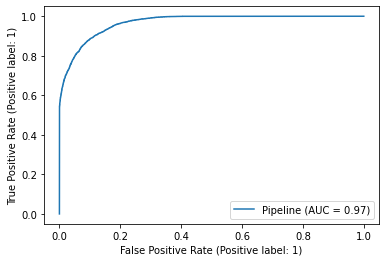

In [121]:
plot_roc_curve(avg1_model.model.fit(X_train, y_train), X_train, y_train);

In [138]:
with open('avg2_model.sav', 'rb') as f:
    avg2_model = pickle.load(f)
avg2_model

In [139]:
plot_roc_curve(avg2_model.model.fit(X_train, y_train), X_train, y_train);

ValueError: Expected 'estimator' to be a binary classifier, but got NoneType

### Final Model

<span class="mark">Visualization.</span>

### Next Steps

With more time we could run and tune more models. More and better models could improve our models performance.